In [ ]:
# import some common libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
# Code to read file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# install FoodRec liberary
!pip install git+https://github.com/DeepFoodRec/Food-Recognition.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/DeepFoodRec/Food-Recognition.git to /tmp/pip-req-build-rqao3gx0
  Running command git clone --filter=blob:none --quiet https://github.com/DeepFoodRec/Food-Recognition.git /tmp/pip-req-build-rqao3gx0
  Resolved https://github.com/DeepFoodRec/Food-Recognition.git to commit c946de567fade2a643c881302c498bb517ee6bc3
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.1 MB/s eta 0:00:00
  Created wheel for FoodRec: filename=FoodRec-0.1.2-py3-none-any.whl size=21142 sha256=f18c5e20790545fb92eb65747b4161c2237e2f8be5a6fed28f08bc2cd5b9ab92
  Stored in directory: /tmp/pip-ephem-whee

#1. User-biased Food Recognition

In [ ]:
import FoodRec as recognition

# load the model from FoodRec liberary
device = torch.device("cuda:0")
#device = torch.device("cpu")
UbFoodRec=recognition.UbFoodRec()
UbFoodRec = UbFoodRec

# load the modle pretrained wieghts
id='1sYV6NasEvQ_mXbcGY6UNAQLbs8Z9wtcB'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('UbFoodRec.pth')
pretrained_UbFoodRec = torch.load('UbFoodRec.pth')

pretrained_UbFoodRec = pretrained_UbFoodRec.to(device)

In [ ]:
class_names=['Almond', 'Apple', 'Arugula', 'Banana', 'Beans', 'Biscuits', 'Blueberry', 'Bread', 'BreadStick', 'Cake', 'Carrot', 'Cereal', 'Cheese', 'Chicken', 'Chickpeas', 'Chips', 'Chocolate', 'Coffee', 'Corn', 'Cracker', 'Croissant', 'Doughnut', 'Egg', 'Fish', 'Grape', 'Green Tea', 'Jam', 'Juice', 'Lentil', 'Meat', 'Milk', 'Mushroom', 'Orange', 'Pasta', 'Peas', 'Pizza', 'Popcorn', 'Pork', 'Potato', 'Rice', 'Salad', 'Soup', 'Speghitti', 'Strawberry', 'Tea', 'Tomato', 'Tortellini', 'Vegetable', 'Yogurt', 'Zucchini']

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

!mkdir images

--2023-06-26 16:48:15--  https://raw.githubusercontent.com/DeepFoodRec/Food-Recognition/main/images/UbFoodRec/apple_juice.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 370749 (362K) [image/jpeg]
Saving to: ‘images/apple_juice.jpg’

apple_juice.jpg     100%[===================>] 362.06K  --.-KB/s    in 0.04s   

2023-06-26 16:48:15 (10.0 MB/s) - ‘images/apple_juice.jpg’ saved [370749/370749]



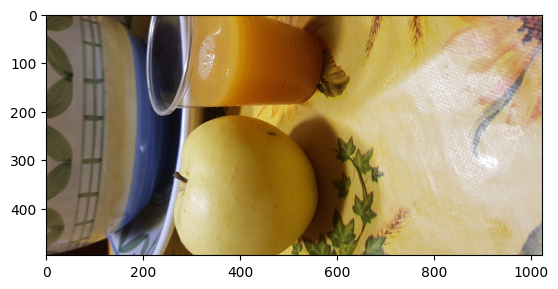

In [ ]:
# load test image
!wget -P images https://raw.githubusercontent.com/DeepFoodRec/Food-Recognition/main/images/UbFoodRec/apple_juice.jpg
img = Image.open('images/apple_juice.jpg')

#!wget -P images https://raw.githubusercontent.com/DeepFoodRec/Food-Recognition/main/images/UbFoodRec/biscuits_coffee.jpg
#img = Image.open('images/biscuits_coffee.jpg')

#!wget -P images https://raw.githubusercontent.com/DeepFoodRec/Food-Recognition/main/images/UbFoodRec/bread_jam_grape.jpg
#img = Image.open('images/bread_jam_grape.jpg')

#!wget -P images https://raw.githubusercontent.com/DeepFoodRec/Food-Recognition/main/images/UbFoodRec/milk_biscuits.jpg
#img = Image.open('images/milk_biscuits.jpg')

plt.imshow(img)

Users Eating Habits

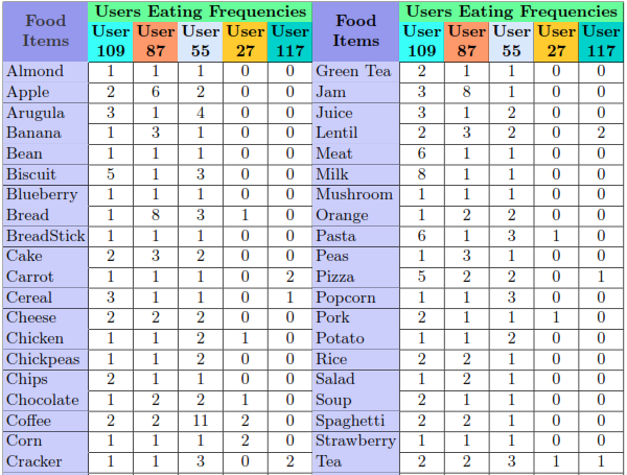

In [ ]:
# transfomr the image and convert it to a batch
img_t = transform(img)
img_batch_t = torch.unsqueeze(img_t, 0).to(device)

# set the model to evaluatin mode
pretrained_UbFoodRec.eval()

# users list
users = [109, 87,55, 27, 117]

# input users verctor and image to to the model to get the predictions for each user
for user in users:
    userVector=torch.zeros(164,1)
    userVector[user][0]=1
    userVector=torch.transpose(userVector,0,1)
    user_input=torch.unsqueeze(userVector, 0).to(device)

    out = pretrained_UbFoodRec(img_batch_t, user_input)

    _, index = torch.max(out, 1)
    percentage = torch.sigmoid(out)[0] * 100
    _, indices = torch.sort(out, descending=True)
    for idx in indices[0][:int(10)+1]:
      print("User => " + str(user), [(class_names[idx], percentage[idx].item())])

    print()


User => 109 [('Juice', 99.87340545654297)]
User => 109 [('Apple', 99.7793197631836)]
User => 109 [('Orange', 99.3502197265625)]
User => 109 [('Coffee', 98.67303466796875)]
User => 109 [('Egg', 97.88587951660156)]
User => 109 [('Green Tea', 97.53759765625)]
User => 109 [('Jam', 97.09580993652344)]
User => 109 [('Banana', 96.41471099853516)]
User => 109 [('Cracker', 93.11248779296875)]
User => 109 [('Biscuits', 92.91436767578125)]
User => 109 [('Potato', 91.90792083740234)]

User => 87 [('Apple', 99.95510864257812)]
User => 87 [('Orange', 99.83058166503906)]
User => 87 [('Juice', 99.80815887451172)]
User => 87 [('Banana', 99.58836364746094)]
User => 87 [('Jam', 98.89759826660156)]
User => 87 [('Coffee', 98.84318542480469)]
User => 87 [('Bread', 98.83162689208984)]
User => 87 [('Egg', 96.59333801269531)]
User => 87 [('Green Tea', 95.46434783935547)]
User => 87 [('Cracker', 94.52616882324219)]
User => 87 [('Potato', 93.94524383544922)]

User => 55 [('Coffee', 99.89131927490234)]
User => 55

#2. Convolutional Deconvolutional Pyramid Network (CDPN)

In [ ]:
import FoodRec as segmentation

In [ ]:
CLASSES = [ 'bg', 'pasta',  'apple','beans', 'boiled egg', 'chicken breast', 'rice', 'salad', 'steak', 'fried egg']

In [ ]:
# load CDPN model from the FoodRec liberary
ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'softmax'

# create segmentation model
CDPN =segmentation.CDPN(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

CDPN=CDPN.to(device)

preprocessing_fn = segmentation.resnet.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)


print(CDPN)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:00<00:00, 249MB/s]


CDPN(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [ ]:
# load the modle pretrained wieghts
id='1JUJKRoonsLtBNyluYJFZpOhJgUFApDVA'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('CDPN.pth')
pretrained_CDPN = torch.load('CDPN.pth')

pretrained_CDPN=pretrained_CDPN.to(device)

In [ ]:
class Dataset(BaseDataset):

    #CLASSES = [ 'bg', 'pasta',  'apple','beans', 'boiled egg', 'chicken breast', 'rice', 'salad', 'steak', 'fried egg']

    def __init__(
            self,
            images_dir,
            masks_dir,
            classes=None,
            augmentation=None,
            preprocessing=None,
    ):
        self.idsx = sorted(os.listdir(images_dir))
        self.idsy = sorted(os.listdir(masks_dir))

        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.idsx]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.idsy]

        self.class_values = [classes.index(cls.lower()) for cls in classes]

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.idsx)

In [ ]:
import albumentations as albu

def transform():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(512, 512),
        albu.CenterCrop(height=416, width=512, always_apply=True)
    ]
    return albu.Compose(test_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):

    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)



In [ ]:
!mkdir segImages

!wget -P segImages https://raw.githubusercontent.com/DeepFoodRec/Food-Recognition/main/images/segImages/apple.png
img = Image.open('segImages/apple.png')

!wget -P segImages https://raw.githubusercontent.com/DeepFoodRec/Food-Recognition/main/images/segImages/bean.png
img = Image.open('segImages/bean.png')

!wget -P segImages https://raw.githubusercontent.com/DeepFoodRec/Food-Recognition/main/images/segImages/egg.png
img = Image.open('segImages/egg.png')

!wget -P segImages https://raw.githubusercontent.com/DeepFoodRec/Food-Recognition/main/images/segImages/lunch.png
img = Image.open('segImages/lunch.png')

!wget -P segImages https://raw.githubusercontent.com/DeepFoodRec/Food-Recognition/main/images/segImages/salad.png
img = Image.open('segImages/salad.png')

--2023-06-26 16:53:37--  https://raw.githubusercontent.com/DeepFoodRec/Food-Recognition/main/images/segImages/apple.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252817 (247K) [image/png]
Saving to: ‘segImages/apple.png’

apple.png           100%[===================>] 246.89K  --.-KB/s    in 0.03s   

2023-06-26 16:53:37 (9.24 MB/s) - ‘segImages/apple.png’ saved [252817/252817]

--2023-06-26 16:53:37--  https://raw.githubusercontent.com/DeepFoodRec/Food-Recognition/main/images/segImages/bean.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response

In [ ]:

testImages='segImages'
# create test dataset
test_dataset = Dataset(
    testImages,
    testImages,
    augmentation=transform(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)


/usr/local/lib/python3.10/dist-packages/FoodRec/base/modules.py:102: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


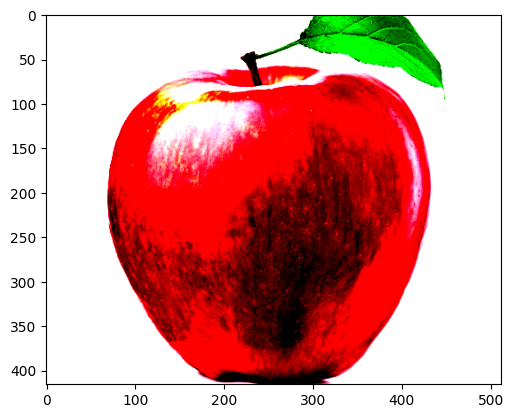

In [ ]:

image, gt_mask = test_dataset[0]  # change value here 0,1,2,3,4

x_tensor = torch.from_numpy(image).to(device).unsqueeze(0)
pr_mask = pretrained_CDPN.predict(x_tensor)

imaget = image.transpose(1, 2, 0)
plt.imshow(imaget)

In [ ]:
segMap = torch.argmax(pr_mask.squeeze(), dim=0).detach().cpu().numpy()


In [ ]:
# Define the function to Visualize the segmentation map in RGB
def decode_segmap(image, nc=10):

  label_colors = np.array([
(50, 50, 225),(249, 0, 0),(0,255, 255),(27, 219, 126),(0, 250, 0),(87, 168, 216),
(220, 175, 85),(221, 50, 50),(249, 234, 123),(5, 100, 50)
])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)

  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]

  rgb = np.stack([r, g, b], axis=2)
  return rgb

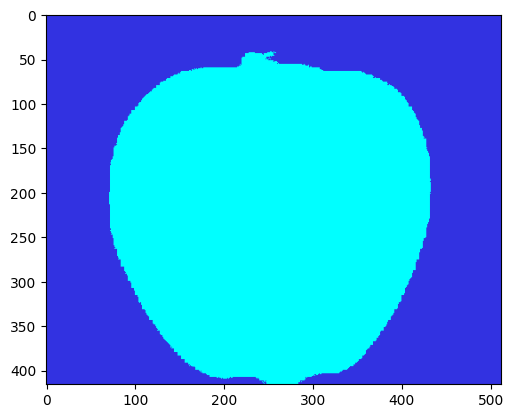

In [ ]:
segMapRGB = decode_segmap(segMap)
plt.imshow(segMapRGB);

#3. Food Convolutional Deconvolutional Network (FCDN)

In [ ]:
# load FCDN model from the FoodRec liberary
ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'softmax'

# create segmentation model
FCDN =segmentation.FCDN(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

FCDN=FCDN.to(device)

preprocessing_fn = segmentation.resnet.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

print(FCDN)

FCDN(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      